# DONT USE THIS ONE Stock Analysis using Google Search Analytics

Should I buy or sell a specific stock today based off of how popular it is on google searches?

Group 1 <br>
3 August 2021 <br>
BAIS 6040: Data Programming in Python <br>

## Introduction

The recent rise of retail investors and day traders, as seen in news stories pertaining to GameStop and AMC, coupled with the increase in internet usage for research, and general information sharing purposes over the last 20 years poses an interesting question as to how stock price and search engine hits (such as Google searches) are tied together. More specifically our team analyzed how a desired company’s closing stock price can be affected by “Google Trends” search interest data to see if there is a strong enough correlation to build a model that would accurately predict a price increase for a given day and therefore could generate a “buy signal” for traders.
	
   Factors of importance needed to develop an acceptable model will include: previous day’s share price, volume of shares trade, and Google Trends search history score, which is a number between 0-100 that is base lined  off of the highest search interest day in a given time period. Data can be pulled direct from most finance sites and the Google Trend website. We then added a few manually calculated relationship fields, such as whether or not the price or trend increases the previous day to enhance our models. Our model will be built and trained primarily on data from Q2 in calendar year 2021 (April – June) and will be tested on July 2021 data. The models performance will be easily analyzed by comparing the predicted values to the actual values. 

## Import

In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import os
import math
import plotly.express as px
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px
import random as rnd
from datetime import date
from datetime import timedelta
from pytrends.request import TrendReq
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score, classification_report
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split    # For generating test/train
from sklearn.linear_model import LinearRegression   # Logistic regression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
%matplotlib inline

## Global Variables and Initialization

In [16]:
dataDir = r"./Data Files/"  #Directory of all data
today = date.today()  # Todays date
rnd.seed(1024)

## Global Functions

In [17]:
# Function gets stock data and trend data if needed
def get_data(ticker):
    if os.path.exists(f"{dataDir}{ticker}_{today}_year.csv"):
        #Get stored data
        stored_data = pd.read_csv(f"{dataDir}{ticker}_{today}_year.csv")
        # Get rid of index name
        stored_data.set_index('Unnamed: 0', inplace=True)
        stored_data.index.name = None
        return stored_data
    else:
        #Get new data
        # Connect to Google API
        pytrends = TrendReq(hl='en-US', tz=360)
        # Set Keyword
        kw_list = [ticker]
        # Google API only shows last 90 days so need to itirate
        # Set start of interval
        date90front = date.today()
        # Initiate dataframe
        trend_data = pd.DataFrame()
        for x in range(4):
            # Set start end of interval
            date90back = date90front - timedelta(days=90)
            # Build Payload of 90 days
            pytrends.build_payload(kw_list,
                                   timeframe=f'{date90back} {date90front}',
                                   geo='')
            trend_90 = pytrends.interest_over_time()
            trend_data = pd.concat([trend_90, trend_data])
            date90front = date90back
        # Get Stock Data
        stock_data = yf.download(ticker,
                                 start=date.today() - timedelta(days=360),
                                 end=date.today(), interval="1d")
        # Combine Data
        new_data = stock_data.join(trend_data)
        # Create index and add date column
        new_data.reset_index(inplace=True)
        new_data.rename(columns= {"index":"Date"}, inplace = True)
        # Rename search interest
        new_data.rename(columns = {ticker: "Search Interest"},inplace = True)
        # Add difference
        new_data["Price Difference"] = new_data["Close"] - new_data["Open"]
        # Add truth value that determines if we want to buy or not that day
        new_data['Buy'] = np.where(new_data['Price Difference'] > 0, 1, 0)
        # Delete isPartial
        del new_data['isPartial']
        # Remove NaN
        new_data.dropna(inplace=True)  
        # Export to data folder
        new_data.to_csv(f"{dataDir}{ticker}_{today}_year.csv")
        return new_data

# Function prints metrics of regression model
def PrintMetricsRegression(test, predictions):
    print(f"Score: {explained_variance_score(test, predictions):.2f}")
    print(f"MAE: {mean_absolute_error(test, predictions):.2f}")
    print(f"RMSE: {math.sqrt(mean_squared_error(test, predictions)):.2f}")
    print(f"r2: {r2_score(test, predictions):.2f}")

# Function prints metrics of classification model
def PrintMetricsClassiffication(test, predictions):
    print("Confusion Matrix:")
    print(confusion_matrix(test, predictions))
    print("------------------")
    print(f"Accuracy: {accuracy_score(test, predictions):.2f}")
    print(f"Recall: {recall_score(test, predictions):.2f}")
    print(f"Prediction: {precision_score(test, predictions):.2f}")
    print(f"f-measure: {fbeta_score(test, predictions, beta=1):.2f}")
    print("------------------")
    print(classification_report(test, predictions))


# Functions gets random data for predictions
def prepareDataForPredictions(X_df):
    numElements = 3
    amcStockPreparedData = []
    for _ in range(numElements):
        dict = {}
        for column in X.columns:
            min = 0  # assume min = 0
            maxValue = round(max(X_df[column].values))
            dict[column] = rnd.randint(min, maxValue)
        amcStockPreparedData.append(dict)
    return amcStockPreparedData

# Create categorical dummies
def createCategoricalDummies(dataFrame, categoryList):
    return pd.get_dummies(dataFrame[categoryList], prefix_sep = "::", drop_first = True)

## Stock to Analyze

In [18]:
# Gets Data for last year
StockSearch_df = get_data("GME")
StockSearch_df

,Date,Open,High,Low,Close,Adj Close,Volume,Search Interest,Price Difference,Buy
0,2020-07-29,3.940000,4.180000,3.920000,4.060000,4.060000,2879600,27.0,0.120000,1
1,2020-07-30,4.000000,4.230000,3.970000,4.100000,4.100000,2398500,21.0,0.100000,1
2,2020-07-31,4.060000,4.160000,3.990000,4.010000,4.010000,1879400,19.0,-0.050000,0
3,2020-08-03,4.030000,4.250000,4.000000,4.150000,4.150000,2517600,13.0,0.120000,1
4,2020-08-04,4.130000,4.740000,4.130000,4.430000,4.430000,10361400,21.0,0.300000,1
...,...,...,...,...,...,...,...,...,...,...
244,2021-07-15,160.000000,171.990005,158.009995,166.820007,166.820007,4298600,31.0,6.820007,1
245,2021-07-16,170.149994,179.470001,166.300003,169.039993,169.039993,3278800,29.0,-1.110001,0
246,2021-07-19,163.300003,176.000000,161.220001,173.490005,173.490005,2436900,32.0,10.190002,1
247,2021-07-20,173.899994,193.639999,172.419998,191.179993,191.179993,3094100,35.0,17.279999,1


## Analytics Model 1 w/ plots

In [19]:
featureColumns=['Search Interest', 'Open']
targetColumn = 'Close'

X=StockSearch_df[featureColumns]
y=StockSearch_df[targetColumn]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.08, shuffle=False)

#### Create the regression

In [20]:
lr = LinearRegression()
lr

LinearRegression()

#### Fit Linear Model

In [21]:
lr.fit(X_train, y_train)

LinearRegression()

#### Our Confidence in our model is high

In [22]:
lr.score(X_train, y_train) 

0.9710175411015066

In [23]:
lr.score(X_test, y_test) 

0.7278862618082327

lr.score(X_test, y_test) 

#### Print the prediction believed accuracy using the model

In [24]:
predictions = lr.predict(X_test)
PrintMetricsRegression(y_test, predictions)

Score: 0.81
MAE: 6.34
RMSE: 8.48
r2: 0.73


#### Test our model using LastMonth data

In [25]:
LastMonth_columns = ["Date","Search Interest","Open","Close"]
LastMonth_df = StockSearch_df[LastMonth_columns].loc[X_test.index]
LastMonth_df["Predicted Close"] = predictions
LastMonth_df


,Date,Search Interest,Open,Close,Predicted Close
229,2021-06-23,41.0,221.449997,219.339996,214.664459
230,2021-06-24,34.0,221.160004,212.309998,214.855186
231,2021-06-25,35.0,214.000000,209.509995,207.860645
232,2021-06-28,33.0,211.250000,213.250000,205.334710
233,2021-06-29,30.0,213.589996,210.880005,207.800609
234,2021-06-30,30.0,209.690002,214.139999,204.027414
235,2021-07-01,28.0,213.399994,204.360001,207.751439
236,2021-07-02,28.0,204.800003,202.830002,199.431056
237,2021-07-06,26.0,204.000000,199.559998,198.791718
238,2021-07-07,26.0,196.000000,190.660004,191.051819


## Analytics Model 2 w/ Plots

In [26]:
StockSearch_df['Previous Open'] = StockSearch_df['Open'].shift(1)
StockSearch_df['Previous High'] = StockSearch_df['High'].shift(1)
StockSearch_df['Previous Low'] = StockSearch_df['Low'].shift(1)
StockSearch_df['Previous Close'] = StockSearch_df['Close'].shift(1)
StockSearch_df['Previous Adj Close'] = StockSearch_df['Adj Close'].shift(1)
StockSearch_df['Previous Volume'] = StockSearch_df['Volume'].shift(1)
StockSearch_df['Previous Search Interest'] = StockSearch_df['Search Interest'].shift(1)
StockSearch_df.dropna(inplace=True)

StockSearch_df

,Date,Open,High,Low,Close,Adj Close,Volume,Search Interest,Price Difference,Buy,Previous Open,Previous High,Previous Low,Previous Close,Previous Adj Close,Previous Volume,Previous Search Interest
1,2020-07-30,4.000000,4.230000,3.970000,4.100000,4.100000,2398500,21.0,0.100000,1,3.940000,4.180000,3.920000,4.060000,4.060000,2879600.0,27.0
2,2020-07-31,4.060000,4.160000,3.990000,4.010000,4.010000,1879400,19.0,-0.050000,0,4.000000,4.230000,3.970000,4.100000,4.100000,2398500.0,21.0
3,2020-08-03,4.030000,4.250000,4.000000,4.150000,4.150000,2517600,13.0,0.120000,1,4.060000,4.160000,3.990000,4.010000,4.010000,1879400.0,19.0
4,2020-08-04,4.130000,4.740000,4.130000,4.430000,4.430000,10361400,21.0,0.300000,1,4.030000,4.250000,4.000000,4.150000,4.150000,2517600.0,13.0
5,2020-08-05,4.500000,4.760000,4.250000,4.630000,4.630000,4919300,21.0,0.130000,1,4.130000,4.740000,4.130000,4.430000,4.430000,10361400.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2021-07-15,160.000000,171.990005,158.009995,166.820007,166.820007,4298600,31.0,6.820007,1,180.490005,182.380005,165.070007,167.619995,167.619995,3913800.0,28.0
245,2021-07-16,170.149994,179.470001,166.300003,169.039993,169.039993,3278800,29.0,-1.110001,0,160.000000,171.990005,158.009995,166.820007,166.820007,4298600.0,31.0
246,2021-07-19,163.300003,176.000000,161.220001,173.490005,173.490005,2436900,32.0,10.190002,1,170.149994,179.470001,166.300003,169.039993,169.039993,3278800.0,29.0
247,2021-07-20,173.899994,193.639999,172.419998,191.179993,191.179993,3094100,35.0,17.279999,1,163.300003,176.000000,161.220001,173.490005,173.490005,2436900.0,32.0


In [27]:
columns = ["Previous Open", "Previous High", "Previous Low", "Previous Close", "Previous Volume", "Previous Search Interest", "Close"]
StockSearch_df = StockSearch_df[columns]
StockSearch_df

,Previous Open,Previous High,Previous Low,Previous Close,Previous Volume,Previous Search Interest,Close
1,3.940000,4.180000,3.920000,4.060000,2879600.0,27.0,4.100000
2,4.000000,4.230000,3.970000,4.100000,2398500.0,21.0,4.010000
3,4.060000,4.160000,3.990000,4.010000,1879400.0,19.0,4.150000
4,4.030000,4.250000,4.000000,4.150000,2517600.0,13.0,4.430000
5,4.130000,4.740000,4.130000,4.430000,10361400.0,21.0,4.630000
...,...,...,...,...,...,...,...
244,180.490005,182.380005,165.070007,167.619995,3913800.0,28.0,166.820007
245,160.000000,171.990005,158.009995,166.820007,4298600.0,31.0,169.039993
246,170.149994,179.470001,166.300003,169.039993,3278800.0,29.0,173.490005
247,163.300003,176.000000,161.220001,173.490005,2436900.0,32.0,191.179993


In [28]:
features = list(StockSearch_df.columns)
features.remove("Close")
target = "Close"

X = StockSearch_df[features]
y = StockSearch_df[target]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, shuffle=False)

In [30]:
lr = LinearRegression()
lr

LinearRegression()

In [31]:
lr.fit(X_train, y_train)

LinearRegression()

In [32]:
lr.score(X_train, y_train)

0.9440395741236111

In [33]:
lr.score(X_test, y_test)

0.4234289080531545

In [34]:
predictions = lr.predict(X_test)
PrintMetricsRegression(y_test, predictions)


Score: 0.50
MAE: 19.20
RMSE: 26.06
r2: 0.42


In [35]:
predictions = lr.predict(X_test)
predictions

array([187.10329352, 176.32886442, 160.82583767, 162.53827491,
       174.25152919, 180.57468843, 225.01500207, 232.71905728,
       260.47556889, 185.55024337, 244.13877434, 293.12717488,
       225.72553408, 234.98339948, 278.43689021, 325.34125417,
       294.05263337, 162.85595856, 217.33239181, 202.29076584,
       195.64404304, 216.42307449, 220.5171431 , 202.04257254,
       177.56351632, 206.92225017, 201.06524112, 202.78038476,
       185.05611024, 216.32422918, 197.75344481, 205.31329969,
       190.86154836, 185.98736471, 182.44307833, 166.64560702,
       193.41269084, 182.84006507, 184.83563906, 167.36347579,
       151.42637628, 167.40090555, 168.34183288, 172.56050135,
       194.79891757])

In [36]:
X_test = X_test.copy()
X_test['Predicted Close'] = predictions
X_test

,Previous Open,Previous High,Previous Low,Previous Close,Previous Volume,Previous Search Interest,Predicted Close
204,159.850006,182.500000,159.000000,180.600006,7462100.0,38.0,187.103294
205,174.539993,189.199997,168.270004,180.669998,7738700.0,50.0,176.328864
206,171.990005,178.979996,164.149994,168.830002,4825900.0,36.0,160.825838
207,170.789993,174.910004,166.899994,170.490005,2478200.0,31.0,162.538275
208,171.000000,179.240005,170.330002,176.789993,3654700.0,31.0,174.251529
209,175.850006,188.460007,173.350006,180.009995,4664300.0,36.0,180.574688
210,181.000000,217.110001,181.000000,209.429993,14887500.0,59.0,225.015002
211,229.000000,248.479996,225.550003,242.559998,21119900.0,100.0,232.719057
212,229.800003,264.000000,227.000000,254.130005,15526300.0,80.0,260.475569
213,262.970001,268.799988,221.429993,222.000000,11751400.0,74.0,185.550243


In [37]:
stockPrice = StockSearch_df.rename(columns={'Close': 'Actual Close'})
predictedPrice = pd.concat([stockPrice, X_test], axis=1)
predictedPrice.dropna(inplace=True)
predictedPrice

,Previous Open,Previous High,Previous Low,Previous Close,Previous Volume,Previous Search Interest,Actual Close,Previous Open,Previous High,Previous Low,Previous Close,Previous Volume,Previous Search Interest,Predicted Close
204,159.850006,182.500000,159.000000,180.600006,7462100.0,38.0,180.669998,159.850006,182.500000,159.000000,180.600006,7462100.0,38.0,187.103294
205,174.539993,189.199997,168.270004,180.669998,7738700.0,50.0,168.830002,174.539993,189.199997,168.270004,180.669998,7738700.0,50.0,176.328864
206,171.990005,178.979996,164.149994,168.830002,4825900.0,36.0,170.490005,171.990005,178.979996,164.149994,168.830002,4825900.0,36.0,160.825838
207,170.789993,174.910004,166.899994,170.490005,2478200.0,31.0,176.789993,170.789993,174.910004,166.899994,170.490005,2478200.0,31.0,162.538275
208,171.000000,179.240005,170.330002,176.789993,3654700.0,31.0,180.009995,171.000000,179.240005,170.330002,176.789993,3654700.0,31.0,174.251529
209,175.850006,188.460007,173.350006,180.009995,4664300.0,36.0,209.429993,175.850006,188.460007,173.350006,180.009995,4664300.0,36.0,180.574688
210,181.000000,217.110001,181.000000,209.429993,14887500.0,59.0,242.559998,181.000000,217.110001,181.000000,209.429993,14887500.0,59.0,225.015002
211,229.000000,248.479996,225.550003,242.559998,21119900.0,100.0,254.130005,229.000000,248.479996,225.550003,242.559998,21119900.0,100.0,232.719057
212,229.800003,264.000000,227.000000,254.130005,15526300.0,80.0,222.000000,229.800003,264.000000,227.000000,254.130005,15526300.0,80.0,260.475569
213,262.970001,268.799988,221.429993,222.000000,11751400.0,74.0,249.020004,262.970001,268.799988,221.429993,222.000000,11751400.0,74.0,185.550243


Text(0.5, 1.0, 'Predicted Close Price vs. Actual Close Price')

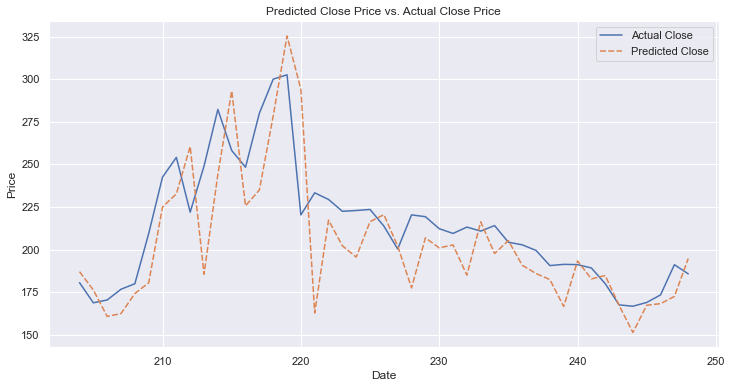

In [38]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize = (12,6))
fig = sns.lineplot(data=predictedPrice[["Actual Close","Predicted Close"]], ax=ax)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Predicted Close Price vs. Actual Close Price")


## Conclusion

You shoud {buy/sell} with this {##%} confidence